In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import warnings
warnings.filterwarnings('ignore')


Training set size: 60000
Test set size: 10000
Number of classes: 10
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

Visualizing sample images...


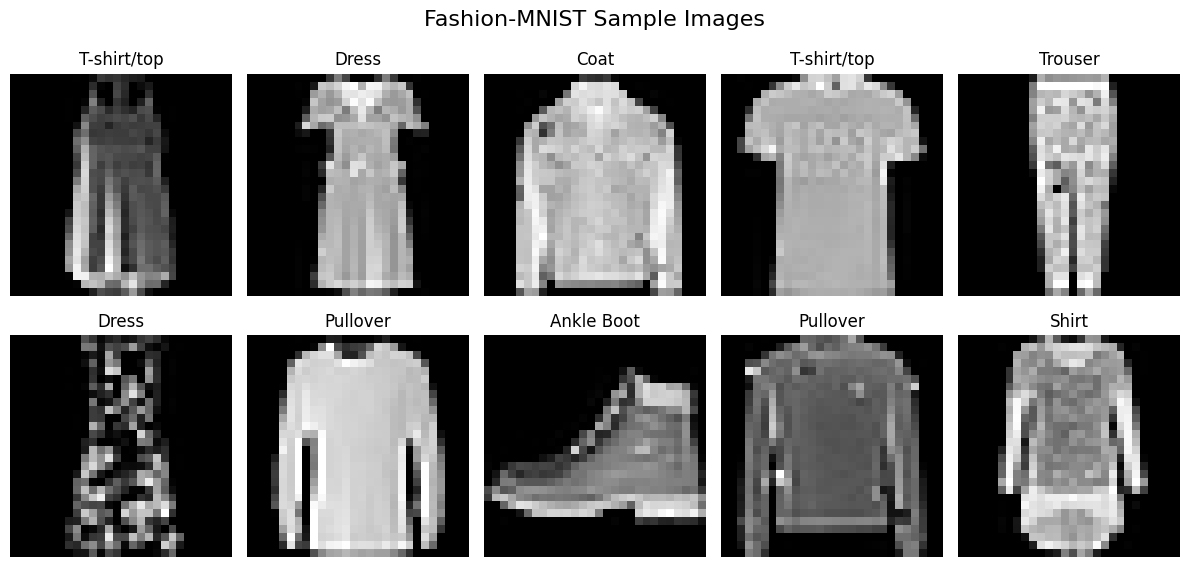

In [4]:
# Define transform to convert PIL images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Download and load Fashion-MNIST dataset
print("\nDownloading Fashion-MNIST dataset...")
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# Function to visualize sample images
def visualize_sample_images(dataset, num_samples=10):
    """Visualize sample images from the dataset"""
    
    # Create subplots
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle('Fashion-MNIST Sample Images', fontsize=16)
    
    # Get random sample indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Get image and label
        image, label = dataset[idx]
        
        # Convert tensor to numpy array and reshape
        image_np = image.numpy().squeeze()
        
        # Plot image
        row = i // 5
        col = i % 5
        axes[row, col].imshow(image_np, cmap='gray')
        axes[row, col].set_title(f'{class_names[label]}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample images
print("\nVisualizing sample images...")
visualize_sample_images(train_dataset)

In [5]:
# Step 3: Data preprocessing for Random Forest

def preprocess_data_for_rf(dataset):
    """
    Preprocess Fashion-MNIST data for Random Forest
    - Flatten 28x28 images to 784 features
    - Convert to numpy arrays
    - Keep pixel values as 0-255 (no normalization needed for RF)
    """
    images = []
    labels = []
    
    print(f"Processing {len(dataset)} samples...")
    
    for i, (image, label) in enumerate(dataset):
        # Convert tensor to numpy and flatten
        image_np = image.numpy().flatten()  # 28x28 -> 784
        images.append(image_np * 255)  # Convert back to 0-255 range
        labels.append(label)
        
        # Progress indicator
        if (i + 1) % 10000 == 0:
            print(f"Processed {i + 1}/{len(dataset)} samples")
    
    return np.array(images), np.array(labels)

print("\nPreprocessing training data...")
X_train, y_train = preprocess_data_for_rf(train_dataset)

print("\nPreprocessing test data...")
X_test, y_test = preprocess_data_for_rf(test_dataset)

# Display preprocessing results
print(f"\nPreprocessing completed!")
print(f"X_train shape: {X_train.shape}")  # Should be (60000, 784)
print(f"y_train shape: {y_train.shape}")  # Should be (60000,)
print(f"X_test shape: {X_test.shape}")    # Should be (10000, 784)  
print(f"y_test shape: {y_test.shape}")    # Should be (10000,)

print(f"\nData ranges:")
print(f"X_train min: {X_train.min()}, max: {X_train.max()}")
print(f"X_test min: {X_test.min()}, max: {X_test.max()}")
print(f"y_train range: {y_train.min()} to {y_train.max()}")
print(f"y_test range: {y_test.min()} to {y_test.max()}")


Preprocessing training data...
Processing 60000 samples...
Processed 10000/60000 samples
Processed 20000/60000 samples
Processed 30000/60000 samples
Processed 40000/60000 samples
Processed 50000/60000 samples
Processed 60000/60000 samples

Preprocessing test data...
Processing 10000 samples...
Processed 10000/10000 samples

Preprocessing completed!
X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)

Data ranges:
X_train min: 0.0, max: 255.0
X_test min: 0.0, max: 255.0
y_train range: 0 to 9
y_test range: 0 to 9



EXPLORATORY DATA ANALYSIS

1. Class Distribution Analysis:

Training set class distribution:
0: T-shirt/top     -  6000 samples (10.0%)
1: Trouser         -  6000 samples (10.0%)
2: Pullover        -  6000 samples (10.0%)
3: Dress           -  6000 samples (10.0%)
4: Coat            -  6000 samples (10.0%)
5: Sandal          -  6000 samples (10.0%)
6: Shirt           -  6000 samples (10.0%)
7: Sneaker         -  6000 samples (10.0%)
8: Bag             -  6000 samples (10.0%)
9: Ankle Boot      -  6000 samples (10.0%)

Test set class distribution:
0: T-shirt/top     -  1000 samples (10.0%)
1: Trouser         -  1000 samples (10.0%)
2: Pullover        -  1000 samples (10.0%)
3: Dress           -  1000 samples (10.0%)
4: Coat            -  1000 samples (10.0%)
5: Sandal          -  1000 samples (10.0%)
6: Shirt           -  1000 samples (10.0%)
7: Sneaker         -  1000 samples (10.0%)
8: Bag             -  1000 samples (10.0%)
9: Ankle Boot      -  1000 samples (10.0%)


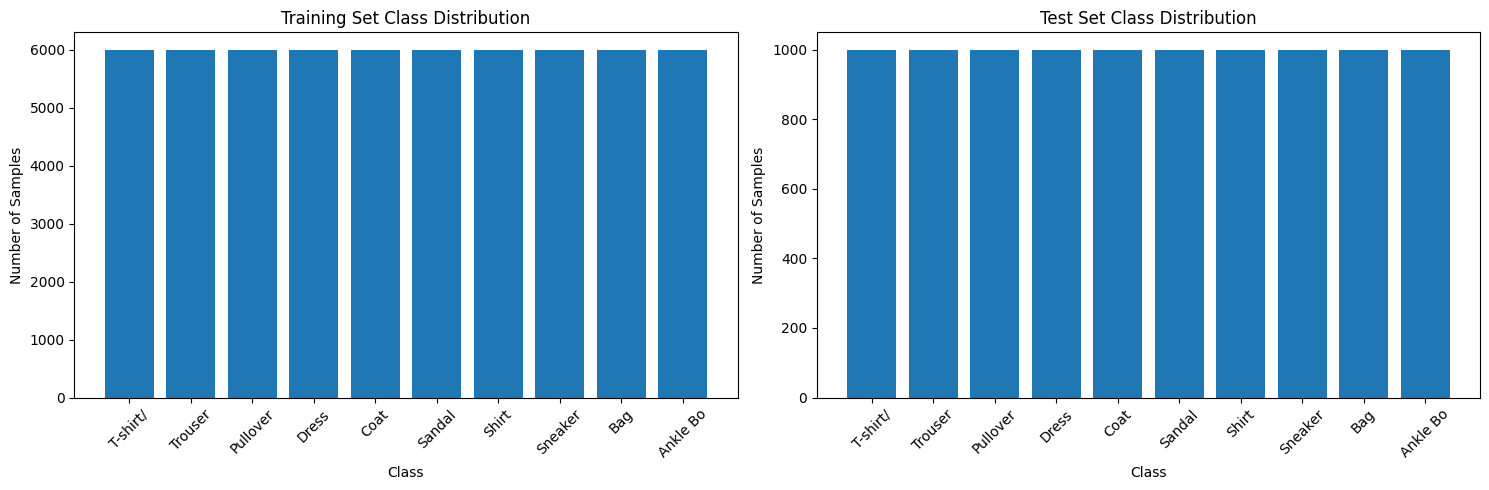


2. Data Statistics:
Training data shape: (60000, 784)
Training data type: float32
Pixel value statistics (training set):
  Mean: 72.94
  Std:  90.02
  Min:  0.00
  Max:  255.00

3. Sample Images from Each Class:


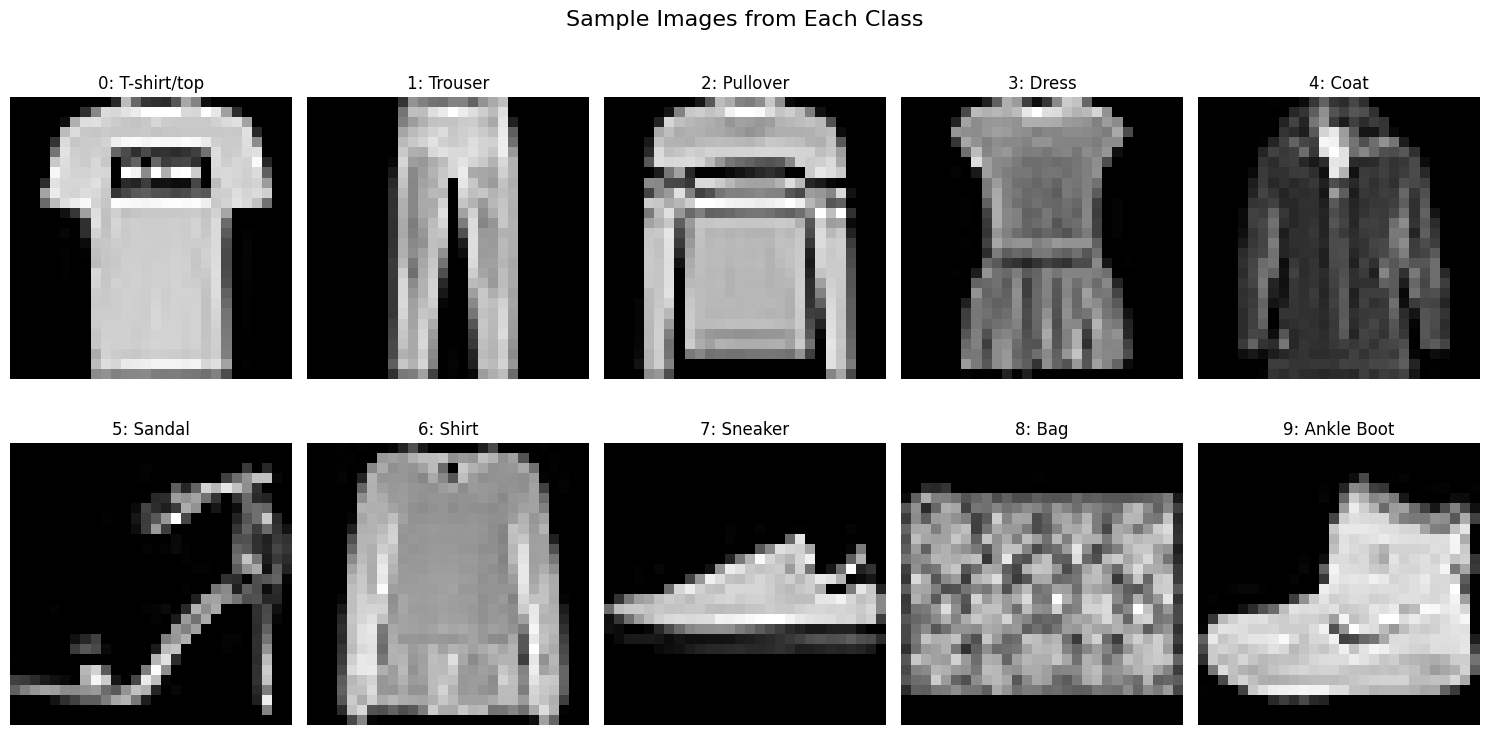


4. Pixel Intensity Analysis:


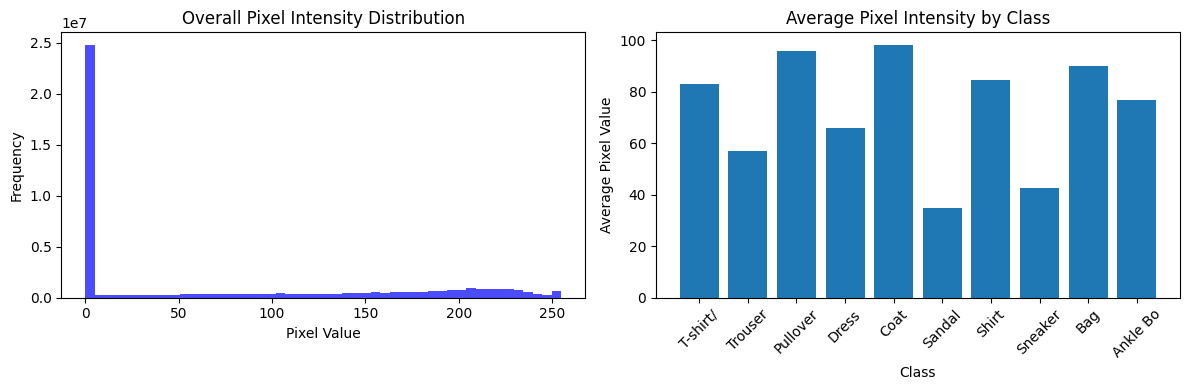


EDA Summary:
✓ Dataset is balanced - each class has ~6000 training samples
✓ Pixel values range from 0.0 to 255.0
✓ Average pixel intensity: 72.9
✓ Data is ready for Random Forest training


In [6]:
# Step 4: Exploratory Data Analysis (EDA)

print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# 4.1 Class Distribution Analysis
print("\n1. Class Distribution Analysis:")
train_class_counts = np.bincount(y_train)
test_class_counts = np.bincount(y_test)

print("\nTraining set class distribution:")
for i, (class_name, count) in enumerate(zip(class_names, train_class_counts)):
    percentage = (count / len(y_train)) * 100
    print(f"{i}: {class_name:<15} - {count:>5} samples ({percentage:.1f}%)")

print("\nTest set class distribution:")
for i, (class_name, count) in enumerate(zip(class_names, test_class_counts)):
    percentage = (count / len(y_test)) * 100
    print(f"{i}: {class_name:<15} - {count:>5} samples ({percentage:.1f}%)")

# 4.2 Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training distribution
ax1.bar(range(10), train_class_counts)
ax1.set_title('Training Set Class Distribution')
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Samples')
ax1.set_xticks(range(10))
ax1.set_xticklabels([name[:8] for name in class_names], rotation=45)

# Test distribution  
ax2.bar(range(10), test_class_counts)
ax2.set_title('Test Set Class Distribution')
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Samples')
ax2.set_xticks(range(10))
ax2.set_xticklabels([name[:8] for name in class_names], rotation=45)

plt.tight_layout()
plt.show()

# 4.3 Data Statistics
print("\n2. Data Statistics:")
print(f"Training data shape: {X_train.shape}")
print(f"Training data type: {X_train.dtype}")
print(f"Pixel value statistics (training set):")
print(f"  Mean: {X_train.mean():.2f}")
print(f"  Std:  {X_train.std():.2f}")
print(f"  Min:  {X_train.min():.2f}")
print(f"  Max:  {X_train.max():.2f}")

# 4.4 Visualize samples from each class
print("\n3. Sample Images from Each Class:")

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for class_idx in range(10):
    # Find first occurrence of each class in training set
    sample_idx = np.where(y_train == class_idx)[0][0]
    
    # Get the image and reshape back to 28x28
    sample_image = X_train[sample_idx].reshape(28, 28)
    
    # Plot
    row = class_idx // 5
    col = class_idx % 5
    axes[row, col].imshow(sample_image, cmap='gray')
    axes[row, col].set_title(f'{class_idx}: {class_names[class_idx]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# 4.5 Pixel intensity distribution
print("\n4. Pixel Intensity Analysis:")
plt.figure(figsize=(12, 4))

# Overall pixel distribution
plt.subplot(1, 2, 1)
plt.hist(X_train.flatten(), bins=50, alpha=0.7, color='blue')
plt.title('Overall Pixel Intensity Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Average pixel intensity per class
plt.subplot(1, 2, 2)
class_means = []
for class_idx in range(10):
    class_mask = y_train == class_idx
    class_mean = X_train[class_mask].mean()
    class_means.append(class_mean)

plt.bar(range(10), class_means)
plt.title('Average Pixel Intensity by Class')
plt.xlabel('Class')
plt.ylabel('Average Pixel Value')
plt.xticks(range(10), [name[:8] for name in class_names], rotation=45)

plt.tight_layout()
plt.show()

print("\nEDA Summary:")
print(f"✓ Dataset is balanced - each class has ~6000 training samples")
print(f"✓ Pixel values range from {X_train.min()} to {X_train.max()}")
print(f"✓ Average pixel intensity: {X_train.mean():.1f}")
print(f"✓ Data is ready for Random Forest training")

In [7]:
# Step 5: Random Forest Model Training

print("\n" + "="*50)
print("RANDOM FOREST MODEL TRAINING")
print("="*50)

# 5.1 Initialize Random Forest Classifier
print("\n1. Initializing Random Forest Classifier...")

# Start with reasonable hyperparameters
rf_classifier = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=20,               # Maximum depth of trees
    min_samples_split=5,        # Minimum samples to split a node
    min_samples_leaf=2,         # Minimum samples in leaf node
    random_state=42,            # For reproducibility
    n_jobs=-1,                  # Use all available cores
    verbose=1                   # Show progress
)

print("Random Forest parameters:")
print(f"  Number of trees: {rf_classifier.n_estimators}")
print(f"  Max depth: {rf_classifier.max_depth}")
print(f"  Min samples split: {rf_classifier.min_samples_split}")
print(f"  Min samples leaf: {rf_classifier.min_samples_leaf}")

# 5.2 Train the model
print("\n2. Training Random Forest...")
print("This may take a few minutes...")

import time
start_time = time.time()

# Fit the model
rf_classifier.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"\n✓ Training completed!")
print(f"Training time: {training_time:.2f} seconds")

# 5.3 Make predictions
print("\n3. Making predictions...")

# Predict on training set
print("Predicting on training set...")
y_train_pred = rf_classifier.predict(X_train)

# Predict on test set  
print("Predicting on test set...")
y_test_pred = rf_classifier.predict(X_test)

print("✓ Predictions completed!")

# 5.4 Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n4. Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Check for overfitting
if train_accuracy - test_accuracy > 0.05:
    print("⚠️  Warning: Possible overfitting detected (train accuracy >> test accuracy)")
else:
    print("✓ Good generalization (reasonable gap between train and test accuracy)")

print(f"\n🎯 Random Forest achieved {test_accuracy*100:.2f}% accuracy on Fashion-MNIST!")


RANDOM FOREST MODEL TRAINING

1. Initializing Random Forest Classifier...
Random Forest parameters:
  Number of trees: 100
  Max depth: 20
  Min samples split: 5
  Min samples leaf: 2

2. Training Random Forest...
This may take a few minutes...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s



✓ Training completed!
Training time: 8.56 seconds

3. Making predictions...
Predicting on training set...
Predicting on test set...
✓ Predictions completed!

4. Model Performance:
Training Accuracy: 0.9878 (98.78%)
Test Accuracy:     0.8762 (87.62%)
⚠️  Warning: Possible overfitting detected (train accuracy >> test accuracy)

🎯 Random Forest achieved 87.62% accuracy on Fashion-MNIST!


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished



DETAILED MODEL EVALUATION

1. Detailed Classification Report:

Test Set Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.86      0.84      1000
     Trouser       1.00      0.96      0.98      1000
    Pullover       0.77      0.79      0.78      1000
       Dress       0.87      0.91      0.89      1000
        Coat       0.76      0.83      0.79      1000
      Sandal       0.98      0.96      0.97      1000
       Shirt       0.74      0.59      0.66      1000
     Sneaker       0.93      0.95      0.94      1000
         Bag       0.96      0.98      0.97      1000
  Ankle Boot       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000


2. Confusion Matrix Analysis:


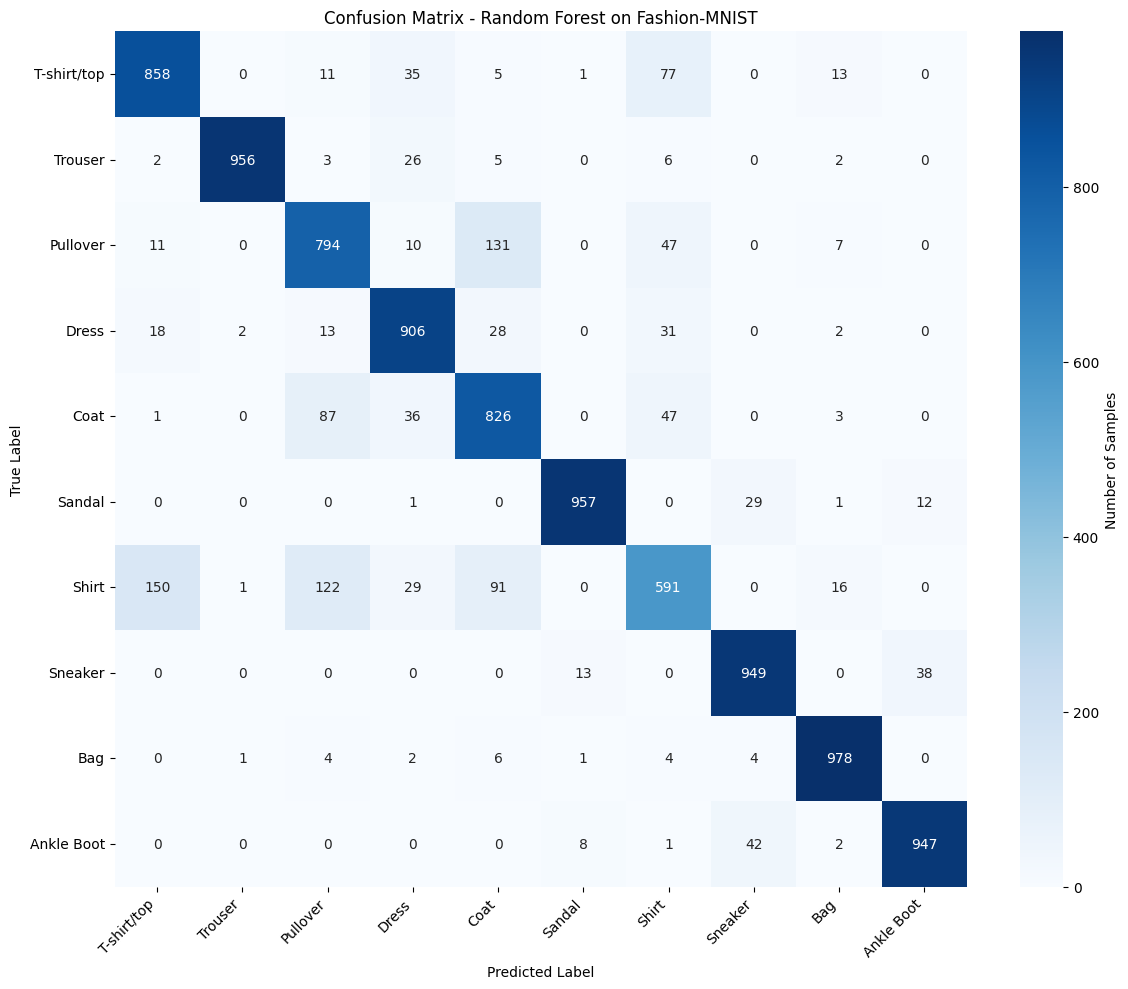


3. Per-Class Performance Analysis:
         Class  Precision  Recall  F1-Score  Support  Accuracy
0  T-shirt/top     0.8250   0.858    0.8412     1000     0.858
1      Trouser     0.9958   0.956    0.9755     1000     0.956
2     Pullover     0.7679   0.794    0.7807     1000     0.794
3        Dress     0.8670   0.906    0.8861     1000     0.906
4         Coat     0.7564   0.826    0.7897     1000     0.826
5       Sandal     0.9765   0.957    0.9667     1000     0.957
6        Shirt     0.7351   0.591    0.6552     1000     0.591
7      Sneaker     0.9268   0.949    0.9377     1000     0.949
8          Bag     0.9551   0.978    0.9664     1000     0.978
9   Ankle Boot     0.9498   0.947    0.9484     1000     0.947

4. Performance Highlights:
🏆 Best performing class:  Trouser (F1: 0.9755)
⚠️  Worst performing class: Shirt (F1: 0.6552)

5. Most Common Misclassifications:

Top 5 misclassification patterns:
1. Shirt → T-shirt/top: 150 cases (1.50%)
2. Pullover → Coat: 131 cases (1.31%

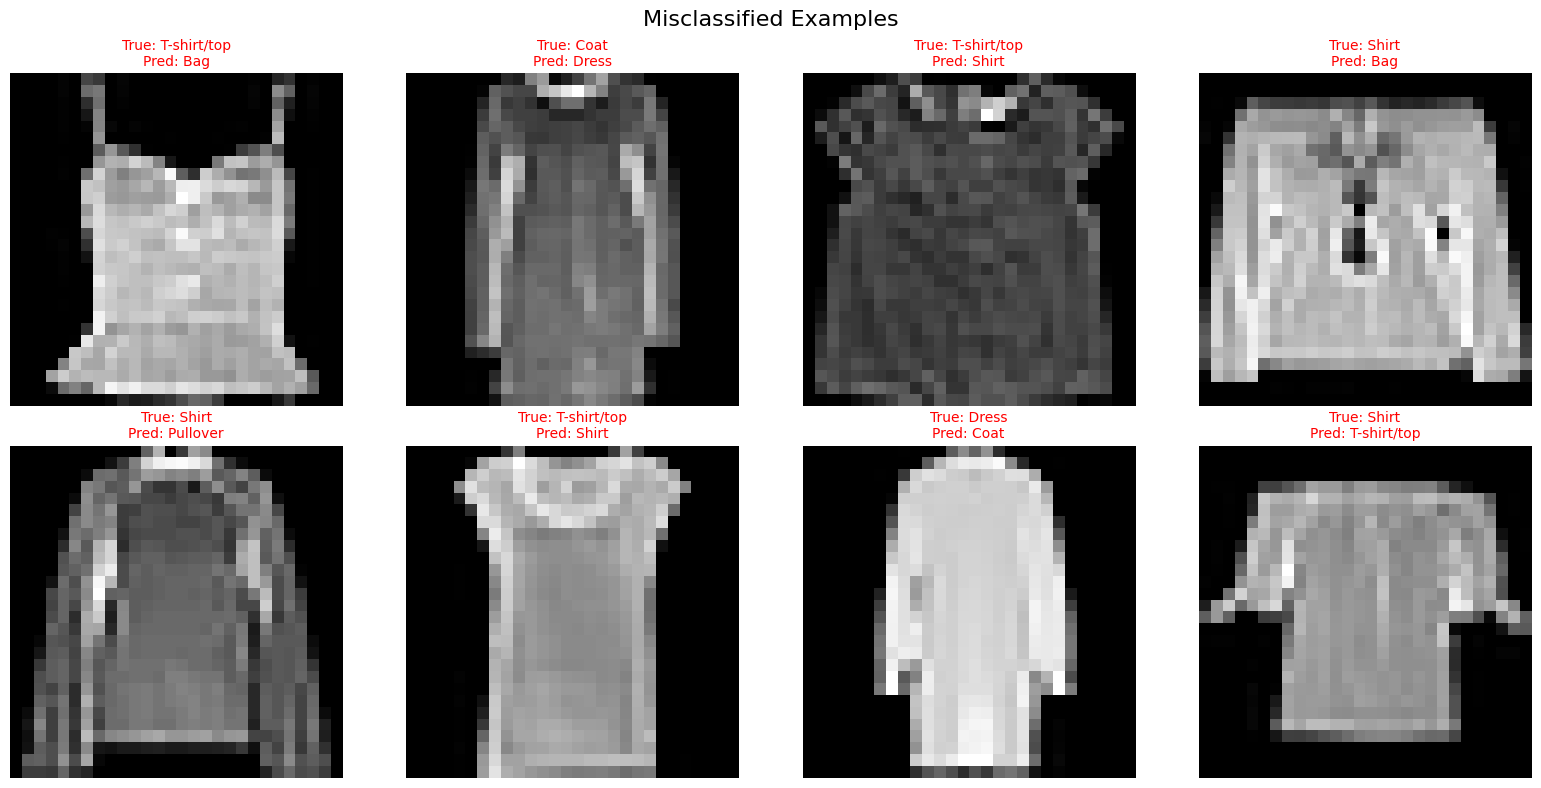


7. Feature Importance Analysis:
Analyzing pixel importance...


AttributeError: 'RandomForestClassifier' object has no attribute 'feature_importance_'

In [10]:
# Step 6: Detailed Model Evaluation

print("\n" + "="*60)
print("DETAILED MODEL EVALUATION")
print("="*60)

# 6.1 Classification Report
print("\n1. Detailed Classification Report:")
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# 6.2 Confusion Matrix
print("\n2. Confusion Matrix Analysis:")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})
plt.title('Confusion Matrix - Random Forest on Fashion-MNIST')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6.3 Per-class Performance Analysis
print("\n3. Per-Class Performance Analysis:")

# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_test_pred)

# Create detailed performance table
performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support,
    'Accuracy': [cm[i,i]/support[i] for i in range(10)]
})

print(performance_df.round(4))

# 6.4 Best and Worst Performing Classes
print(f"\n4. Performance Highlights:")
best_class_idx = np.argmax(f1)
worst_class_idx = np.argmin(f1)

print(f"🏆 Best performing class:  {class_names[best_class_idx]} (F1: {f1[best_class_idx]:.4f})")
print(f"⚠️  Worst performing class: {class_names[worst_class_idx]} (F1: {f1[worst_class_idx]:.4f})")

# 6.5 Most Common Misclassifications
print(f"\n5. Most Common Misclassifications:")

# Find off-diagonal elements (misclassifications)
misclass_pairs = []
for i in range(10):
    for j in range(10):
        if i != j and cm[i,j] > 0:
            misclass_pairs.append((class_names[i], class_names[j], cm[i,j]))

# Sort by frequency and show top 5
misclass_pairs.sort(key=lambda x: x[2], reverse=True)
print("\nTop 5 misclassification patterns:")
for i, (true_class, pred_class, count) in enumerate(misclass_pairs[:5], 1):
    percentage = (count / np.sum(cm)) * 100
    print(f"{i}. {true_class} → {pred_class}: {count} cases ({percentage:.2f}%)")

# 6.6 Visualize Misclassified Examples
print(f"\n6. Visualizing Misclassified Examples:")

def show_misclassified_examples(X_test, y_test, y_pred, num_examples=8):
    """Show examples of misclassified images"""
    
    # Find misclassified indices
    misclassified_mask = y_test != y_pred
    misclassified_indices = np.where(misclassified_mask)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassifications found!")
        return
    
    # Randomly select examples
    selected_indices = np.random.choice(misclassified_indices, 
                                      min(num_examples, len(misclassified_indices)), 
                                      replace=False)
    
    # Plot misclassified examples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Misclassified Examples', fontsize=16)
    
    for i, idx in enumerate(selected_indices):
        row = i // 4
        col = i % 4
        
        # Get image and reshape
        image = X_test[idx].reshape(28, 28)
        true_label = class_names[y_test[idx]]
        pred_label = class_names[y_pred[idx]]
        
        # Plot
        axes[row, col].imshow(image, cmap='gray')
        axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}', 
                                color='red', fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

show_misclassified_examples(X_test, y_test, y_test_pred)

# 6.7 Feature Importance Analysis
print(f"\n7. Feature Importance Analysis:")
print("Analyzing pixel importance...")

# Get feature importances
feature_importances = rf_classifier.feature_importance_

# Reshape back to 28x28 image format
importance_image = feature_importances.reshape(28, 28)

# Plot feature importance as heatmap
plt.figure(figsize=(10, 8))
plt.imshow(importance_image, cmap='hot', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title('Random Forest Feature Importance\n(Pixel-level importance for classification)')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

# Top important pixels
top_pixels = np.argsort(feature_importances)[-20:][::-1]
print(f"\nTop 10 most important pixel positions:")
for i, pixel_idx in enumerate(top_pixels[:10], 1):
    row, col = divmod(pixel_idx, 28)
    importance = feature_importances[pixel_idx]
    print(f"{i:2d}. Pixel ({row:2d},{col:2d}): {importance:.6f}")

print(f"\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"✓ Overall Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"✓ Best performing class: {class_names[best_class_idx]} ({f1[best_class_idx]:.4f} F1)")
print(f"✓ Most challenging class: {class_names[worst_class_idx]} ({f1[worst_class_idx]:.4f} F1)")
print(f"✓ Random Forest baseline established for comparison with neural networks")


In [11]:
# Quick check
print("Model attributes:")
print([attr for attr in dir(rf_classifier) if 'feature' in attr])
print(f"Model fitted: {hasattr(rf_classifier, 'feature_importances_')}")

Model attributes:
['feature_importances_', 'max_features', 'n_features_in_']
Model fitted: True


In [12]:
# Test feature importances directly
feature_importances = rf_classifier.feature_importances_
print(f"Feature importances shape: {feature_importances.shape}")
print(f"Min importance: {feature_importances.min()}")
print(f"Max importance: {feature_importances.max()}")

Feature importances shape: (784,)
Min importance: 0.0
Max importance: 0.011657555894769451


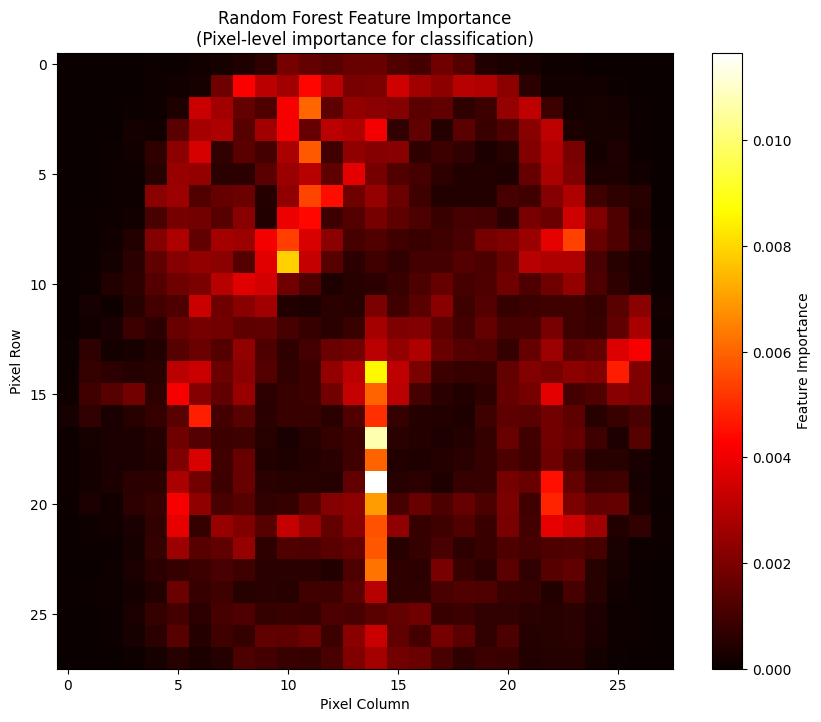


Top 10 most important pixel positions:
 1. Pixel (19,14): 0.011658
 2. Pixel (17,14): 0.010722
 3. Pixel (14,14): 0.008600
 4. Pixel ( 9,10): 0.007889
 5. Pixel (20,14): 0.006971
 6. Pixel (23,14): 0.006259
 7. Pixel ( 2,11): 0.006051
 8. Pixel (18,14): 0.006004
 9. Pixel (15,14): 0.005986
10. Pixel ( 4,11): 0.005815


In [13]:
# Continue with the visualization
importance_image = feature_importances.reshape(28, 28)

# Plot feature importance as heatmap
plt.figure(figsize=(10, 8))
plt.imshow(importance_image, cmap='hot', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title('Random Forest Feature Importance\n(Pixel-level importance for classification)')
plt.xlabel('Pixel Column')
plt.ylabel('Pixel Row')
plt.show()

# Top important pixels
top_pixels = np.argsort(feature_importances)[-20:][::-1]
print(f"\nTop 10 most important pixel positions:")
for i, pixel_idx in enumerate(top_pixels[:10], 1):
    row, col = divmod(pixel_idx, 28)
    importance = feature_importances[pixel_idx]
    print(f"{i:2d}. Pixel ({row:2d},{col:2d}): {importance:.6f}")